# Evaluation of models
per serving / per recipe

provide a class to compare models

In [1]:
import pandas as pd
import numpy as np
import pickle
from PIL import Image
import random 
import re
import ast
import os

import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import r2_score #R square

%matplotlib inline
%config InlineBackend.figure_format='retina'
pd.set_option('display.max_colwidth', 100)
#pd.set_option('mode.chained_assignment', None)

In [46]:
class Evaluator:
    
    pred_calorie = 0
    pred_category = 0
    pred_nutrient = 0
    pred_ingredient = 0
    pred_three_vector = 0
    df_by_index = pd.DataFrame()
    
    def __init__(self, path, output_type):
        self._path = path
        self._output_type = output_type
        if os.path.exists(self._path[:16] + self._path.split('/')[3] + '/pred_' + self._path.split('/')[4][:-3] + '.pkl'):
            self.load_pred_result()
    
    def evaluate_calorie(self, true_calories):
        # plot
        self.__plot_joint_calorie_distribution(true_calories)
        
        # describe
        calorie_table = pd.DataFrame(true_calories, columns=['Truth calories'])
        calorie_table['Predicted calories'] = self.pred_calorie
        print(calorie_table.describe())
        
        ### Quantity evaluation of predicted calories
        # mse
        calorie_error = [float(i-j) for i, j in zip(true_calories, self.pred_calorie)]
        self.__get_regression_loss(true_calories, self.pred_calorie, 'calorie')
        
        relative_error = [i/j for i, j in zip(np.abs(calorie_error), true_calories)]
        mre = np.mean(np.abs(relative_error))
        print("Mean relative errors of calorie: ", mre*100, "%")
        
        # 超过100%的，超过50%的
        self.__abs_calorie_error = np.round(np.abs(calorie_error), 5)
        self.__bad_samples = self.__abs_calorie_error[self.__abs_calorie_error>200]
        self.__good_samples = self.__abs_calorie_error[self.__abs_calorie_error<10]
        
        print("\nSample number with abs error greater than 120kcal:", len(self.__bad_samples))
        print("Sample number with abs error less than 120kcal:", len(self.__good_samples))
        
        print("Sample number with relative error exceeds 50%: ", len([i for i in relative_error if i>0.5]))
        print("Sample number with relative error less than 50%: ", len([i for i in relative_error if i<0.5]))
    
    
    def evaluate_by_category(self, test_data):
        try:
            df = test_data[['calorie_per_recipe', 'category']]
            df['predicted_calorie'] = self.pred_calorie
            print(df.groupby('category').mean())
        except:
            df = test_data[['calorie', 'category']]
            df['predicted_calorie'] = self.pred_calorie
            print(df.groupby('category').mean())
    
    
    # visualize good and bad samples
    def visualize_samples(self, test_data, true_calories, imgs):
        try:
            self.__bad_samples = self.__bad_samples.tolist()
            self.__good_samples = self.__good_samples.tolist()
            self.__abs_calorie_error = self.__abs_calorie_error.tolist()
        except:
            pass
        
        plt.figure(figsize=(18,6))
        #plt.suptitle('Good samples with abs error less than 120kcal', fontsize=15, y=1)
        plt.suptitle('Examples on Successful estimation', fontsize=15, y=1)
        for i in range(3):
            plt.subplot(1,3,i+1)
            good_value = random.choice(self.__good_samples)
            good_index = self.__abs_calorie_error.index(good_value)
            p = self.pred_calorie[good_index]
            t = true_calories[good_index]
            #plt.title("Predicted calorie: %d kcal \nTruth calorie: %d kcal \nName: %s" %(p, t, test_data['file_name'][good_index]))    
            plt.title("Predicted calorie: %d kcal \nTruth calorie: %d kcal \nError: %s kcal" %(p, t, round((t-p)[0],1)))
            plt.imshow(Image.fromarray(np.uint8(imgs[good_index])))
            plt.axis("off")
        
        plt.figure(figsize=(18,6))
        #plt.suptitle('Bad samples with abs error greater than 120kcal', fontsize=15, y=1)
        plt.suptitle('Examples on Failure estimation', fontsize=15, y=1)
        for i in range(3):
            plt.subplot(1,3,i+1)
            bad_value = random.choice(self.__bad_samples)
            bad_index = self.__abs_calorie_error.index(bad_value)
            p = self.pred_calorie[bad_index]
            t = true_calories[bad_index]
            #plt.title("Predicted calorie: %d kcal \nTruth calorie: %d kcal \nName:%s" %(p, t, test_data['file_name'][bad_index])) 
            plt.title("Predicted calorie: %d kcal \nTruth calorie: %d kcal \nError:%s kcal" %(p, t, round((t-p)[0],1))) 
            plt.imshow(Image.fromarray(np.uint8(imgs[bad_index])))
            plt.axis("off")
    
    
    def __plot_joint_calorie_distribution(self, true_calories):
        
        plt.figure(figsize=(10,6))
        plt.title('Predicted and Truth values of calories')
        plt.plot(true_calories, label='true')
        plt.plot(self.pred_calorie, label='pred')

        plt.xlabel('Samples')
        plt.ylabel('Calorie values (kcal)')
        plt.legend()

    
    def predict_and_save_results(self, imgs):
        if os.path.exists(self._path[:16] + self._path.split('/')[3] + '/pred_' + self._path.split('/')[4][:-3] + '.pkl'):
            print("Predicted results exist, try using object.load_pred_result()")
            return
        
        model = load_model(self._path)
        pred_path = self._path[:16] + self._path.split('/')[3] + '/pred_' + self._path.split('/')[4][:-3] + '.pkl'

        if self._output_type == 'calorie':
            self.pred_calorie = model.predict(imgs)
            with open(pred_path, 'wb') as f:
                pickle.dump([self.pred_calorie], f)
        elif self._output_type == 'category':
            self.pred_calorie, self.pred_category = model.predict(imgs)
            with open(pred_path, 'wb') as f:
                pickle.dump([self.pred_calorie, self.pred_category], f)
        elif self._output_type == 'ingredient':
            self.pred_calorie, self.pred_ingredient = model.predict(imgs)
            with open(pred_path, 'wb') as f:
                pickle.dump([self.pred_calorie, self.pred_ingredient], f)
        elif self._output_type == 'nutrient':
            self.pred_calorie, self.pred_nutrient = model.predict(imgs)
            with open(pred_path, 'wb') as f:
                pickle.dump([self.pred_calorie, self.pred_nutrient], f)
        elif self._output_type == 'three_vector':
            self.pred_calorie, self.pred_category, self.pred_nutrient, self.pred_ingredient = model.predict(imgs)
            with open(pred_path, 'wb') as f:
                pickle.dump([self.pred_calorie, self.pred_category, self.pred_nutrient, self.pred_ingredient], f)
    
    
    def load_pred_result(self):
        pred_path = self._path[:16] + self._path.split('/')[3] + '/pred_' + self._path.split('/')[4][:-3] + '.pkl'
        if self._output_type == 'calorie':
            with open(pred_path, 'rb') as f:
                self.pred_calorie = pickle.load(f)[0]
        elif self._output_type == 'category':
            with open(pred_path, 'rb') as f:
                temp = pickle.load(f)
                self.pred_calorie, self.pred_category = temp[0], temp[1]
        elif self._output_type == 'ingredient':
            with open(pred_path, 'rb') as f:
                temp = pickle.load(f)
                self.pred_calorie, self.pred_ingredient = temp[0], temp[1]
        elif self._output_type == 'nutrient':
            with open(pred_path, 'rb') as f:
                temp = pickle.load(f)
                self.pred_calorie, self.pred_nutrient = temp[0], temp[1]
        elif self._output_type == 'three_vector':
            with open(pred_path, 'rb') as f:
                temp = pickle.load(f)
                self.pred_calorie, self.pred_category, self.pred_nutrient, self.pred_ingredient = temp[0], temp[1], temp[2], temp[3]
        

    def plot_training_losses(self):
        pickle_file_path = self._path[:-3]+'.pkl'
        
        with open(pickle_file_path, 'rb') as f:
            history = pickle.load(f)
            
        plt.figure(figsize=(8,4))
        plt.plot(history['loss'], label='train_calorie_loss')
        plt.plot(history['val_loss'], label='val_calorie_loss')

        plt.title("MSE losses of calorie on training and validation set")
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss (kcal²)')
        plt.legend()


    def evaluate_nutrient(self, true_nutrient):
        # nutrient sequence: [fat, carbs, protein]
        # default value = 0
        if type(self.pred_nutrient) == int:
            print('This model does not output nutrient!')
            return
        
        fats_true, fats_pred, carbs_true, carbs_pred, proteins_true, proteins_pred = [], [], [], [], [], []
        for trues, preds in zip(true_nutrient, self.pred_nutrient):
            fats_true.append(trues[0])
            fats_pred.append(preds[0])
            carbs_true.append(trues[1])
            carbs_pred.append(preds[1])
            proteins_true.append(trues[2])
            proteins_pred.append(preds[2])

        self.__get_regression_loss(fats_true, fats_pred, 'fat')
        self.__get_regression_loss(carbs_true, carbs_pred, 'carbs')
        self.__get_regression_loss(proteins_true, proteins_pred, 'protein')
    
    
    def evaluate_by_index(self, test_data, index, ingredient_list):
        
        #category_list = list(test_data['category'].unique())
        category_list = ['bread', 'burger', 'cake', 'cookies', 'pasta', 'pie', 'pizza', 'rice', 'salad', 'sandwich', 'soup', 'steak']
        Calorie, Category, Fat, Carbohydrate, Protein, Ingredients = [], [], [], [], [], []
        
        print('Image name: ', test_data['file_name'][index])
        try:
            Calorie.append(test_data['calorie_per_recipe'][index])
            Calorie.append(self.pred_calorie[index][0])
        except:
            Calorie.append(test_data['calorie'][index])
            Calorie.append(self.pred_calorie[index][0])
        
        # 预测结果只有bread和soup？？
        if self._output_type == 'category':
            Category.append(test_data['category'][index])
            Category.append(category_list[np.argmax(self.pred_category[index])])
            
            self.df_by_index = pd.DataFrame([Calorie, Category])
            self.df_by_index.index = ['Calorie', 'Category']
            self.df_by_index.columns=['True', 'Predicted']
            print(self.df_by_index)
        
        elif  self._output_type == 'nutrient':
            Fat.append(test_data['nutrient_vector'][index][0])
            Fat.append(self.pred_nutrient[index][0])
            Carbohydrate.append(test_data['nutrient_vector'][index][1])
            Carbohydrate.append(self.pred_nutrient[index][1])
            Protein.append(test_data['nutrient_vector'][index][2])
            Protein.append(self.pred_nutrient[index][2])
            
            self.df_by_index = pd.DataFrame([Calorie, Fat, Carbohydrate, Protein])
            self.df_by_index.index = ['Calorie', 'Fat', 'Carbohydrate', 'Protein']
            self.df_by_index.columns=['True', 'Predicted']
            print(self.df_by_index)
        
        # 阈值为4，预测结果只有0，2，3？？？
        elif self._output_type == 'ingredient':
            ingre_index_true = [i for (i, v) in enumerate(test_data['ingredient_vector'][index]) if v > 0.3]
            ingre_index_pred = [i for (i, v) in enumerate(self.pred_ingredient[index]) if v > 0.3]
            Ingredients.append(', '.join([v for i, v in enumerate(ingredient_list) if i in ingre_index_true]))
            Ingredients.append(', '.join([v for i, v in enumerate(ingredient_list) if i in ingre_index_pred]))  
            
            self.df_by_index = pd.DataFrame([Calorie, Ingredients])
            self.df_by_index.index = ['Calorie', 'Ingredients']
            self.df_by_index.columns=['True', 'Predicted']
            print(self.df_by_index)
            
        elif self._output_type == 'three_vector':
            Category.append(test_data['category'][index])
            Category.append(category_list[np.argmax(self.pred_category[index])])
            
            Fat.append(test_data['nutrient_vector'][index][0])
            Fat.append(self.pred_nutrient[index][0])
            Carbohydrate.append(test_data['nutrient_vector'][index][1])
            Carbohydrate.append(self.pred_nutrient[index][1])
            Protein.append(test_data['nutrient_vector'][index][2])
            Protein.append(self.pred_nutrient[index][2])
            
            ingre_index_true = [i for (i, v) in enumerate(test_data['ingredient_vector'][index]) if v > 0.3]
            ingre_index_pred = [i for (i, v) in enumerate(self.pred_ingredient[index]) if v > 0.3]
            Ingredients.append(', '.join([v for i, v in enumerate(ingredient_list) if i in ingre_index_true]))
            Ingredients.append(', '.join([v for i, v in enumerate(ingredient_list) if i in ingre_index_pred]))      

            self.df_by_index = pd.DataFrame([Calorie, Category, Fat, Carbohydrate, Protein, Ingredients])
            self.df_by_index.index = ['Calorie', 'Category', 'Fat', 'Carbohydrate', 'Protein', 'Ingredients']
            self.df_by_index.columns=['True', 'Predicted']
            print(self.df_by_index)
    
    
    def __get_regression_loss(self, true_values, pred_values, target_name):
        
        mean_abs_error = mean_absolute_error(true_values, pred_values)
        rmse = np.sqrt(mean_squared_error(true_values, pred_values))
        r2 = r2_score(true_values, pred_values)

        #mean_abs_error = np.mean(np.abs(error_list)) 
        #rmse = np.sqrt(np.mean(np.square(error_list)))
        
        if target_name == 'calorie':
            print("\nMean absolute errors of calorie: ", mean_abs_error, "kcal")
            print("Root mean squared errors of calorie: ", rmse, "kcal")
            print("R2 score of calorie: ", r2)
            print("Mean absolute percentage error: ", self.__mean_absolute_percentage_error(true_values, pred_values))
        elif target_name == 'fat':
            print("Mean absolute errors of fat: ", mean_abs_error, "grams")
            print("Root mean squared errors of fat: ", rmse, "grams")
            print("R2 score of fat: ", r2)
        elif target_name == 'carbs':
            print("\nMean absolute errors of carbohydrates: ", mean_abs_error, "grams")
            print("Root mean squared errors of carbohydrates: ", rmse, "grams")
            print("R2 score of carbohydrates: ", r2)
        elif target_name == 'protein':
            print("\nMean absolute errors of protein: ", mean_abs_error, "grams")
            print("Root mean squared errors of protein: ", rmse, "grams")
            print("R2 score of protein: ", r2)
    
    def __mean_absolute_percentage_error(self, y_true, y_pred): 
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
            

In [28]:
def load_test_images(test_data, target):
    # read test images using file_name column in the csv file
    
    if target == 'serving': 
        imgs = np.zeros((len(test_data),256,256,3))
        print('Loading', len(test_data), 'test imgs (per serving)...')
        for index, name in enumerate(test_data['file_name']):
            path = './data/all_data/' + name
            img = Image.open(path).resize((256, 256))
            if np.asarray(img).shape != (256,256,3):
                img = Image.open(path).convert('RGB').resize((256, 256))
            imgs[index] = img
                
    
    elif target == 'recipe': 
        imgs = np.zeros((len(test_data),256,256,3))
        print('Loading', len(test_data), 'test imgs (per recipe)...')
        for index, name in enumerate(test_data['file_name']):
            path = './data/all_data/' + name
            img = Image.open(path).resize((256, 256))
            if np.asarray(img).shape != (256,256,3):
                img = Image.open(path).convert('RGB').resize((256, 256))
            imgs[index] = img 
        
    return imgs


def plot_calories_of_models(true_calorie, start, end, model1, model2, model3, model4, model5):
    
    plt.figure(figsize=(10,6))
    
    plt.title('Predicted and Truth values of calories')
    plt.plot(true_calorie[start:end], label='true')
    plt.plot(model1.pred_calorie[start:end], label='cal')
    plt.plot(model2.pred_calorie[start:end], label='cal+category')
    plt.plot(model3.pred_calorie[start:end], label='cal+nutrient')
    plt.plot(model4.pred_calorie[start:end], label='cal+ingredient')
    plt.plot(model5.pred_calorie[start:end], label='cal+3vectors')

    plt.xlabel('Samples')
    plt.ylabel('Calorie values (kcal)')
    plt.legend()

    
def print_mean_baseline_error(train_data, test_data, true_nutrient, target):
    print("Mean baseline evaluation:")
    fat = [i[0] for i in true_nutrient]
    carbs = [i[1] for i in true_nutrient]
    protein = [i[2] for i in true_nutrient]
    
    train_fat_mean = np.mean([i[0] for i in train_data['nutrient_vector']])
    train_carbs_mean = np.mean([i[1] for i in train_data['nutrient_vector']])
    train_protein_mean = np.mean([i[2] for i in train_data['nutrient_vector']])
    
    print("RMSE fat: ", np.sqrt(np.mean(np.square(fat - train_fat_mean))))
    print("RMSE carbs: ", np.sqrt(np.mean(np.square(carbs - train_carbs_mean))))
    print("RMSE protein: ", np.sqrt(np.mean(np.square(protein - train_protein_mean))))
    
    if target == "serving":
        mean_calorie = train_data['calorie'].mean()
        rmse = np.sqrt(np.mean(np.square(test_data['calorie'] - mean_calorie)))
        mae = np.mean(np.abs(test_data['calorie'] - mean_calorie))
        print("Mean calorie per serving: ", mean_calorie)
        print("RMSE calorie: ", rmse)
        print("MAE calorie: ", mae)

    elif target == 'recipe':
        mean_calorie = train_data['calorie_per_recipe'].mean()
        rmse = np.sqrt(np.mean(np.square(test_data['calorie_per_recipe'] - mean_calorie)))  
        mae = np.mean(np.abs(test_data['calorie_per_recipe'] - mean_calorie))
        print("Mean calorie per recipe: ", mean_calorie)
        print("RMSE calorie: ", rmse)
        print("MAE calorie: ", mae)
        
        
def print_random_baseline_error(train_data, test_data, true_nutrient, target):
    print("\nRandom baseline evaluation:")
    fat = [i[0] for i in true_nutrient]
    carbs = [i[1] for i in true_nutrient]
    protein = [i[2] for i in true_nutrient]   
    
    train_fat = [i[0] for i in train_data['nutrient_vector']]
    train_carbs = [i[1] for i in train_data['nutrient_vector']]
    train_protein = [i[2] for i in train_data['nutrient_vector']]
    
    print("RMSE fat: ", np.sqrt(np.mean(np.square([fat[i] - random.choice(train_fat) for i in range(len(fat))]))))
    print("RMSE carbs: ", np.sqrt(np.mean(np.square([carbs[i] - random.choice(train_carbs) for i in range(len(carbs))]))))
    print("RMSE protein: ", np.sqrt(np.mean(np.square([protein[i] - random.choice(train_protein) for i in range(len(protein))]))))
    
    if target == "serving":
        rmse = np.sqrt(np.mean(np.square([test_data['calorie'][i]-random.choice(train_data['calorie']) for i in range(len(test_data))])))
        mae = np.mean(np.abs([test_data['calorie'][i]-random.choice(train_data['calorie']) for i in range(len(test_data))]))
        print("RMSE calorie: ", rmse)
        print("MAE calorie: ", mae)

    elif target == 'recipe':
        rmse = np.sqrt(np.mean(np.square([test_data['calorie_per_recipe'][i]-random.choice(test_data['calorie_per_recipe']) for i in range(len(test_data))])))
        mae = np.mean(np.abs([test_data['calorie_per_recipe'][i]-random.choice(test_data['calorie_per_recipe']) for i in range(len(test_data))]))
        print("RMSE calorie: ", rmse)
        print("MAE calorie: ", mae)

## Evaluate per serving

In [3]:
test_data = pd.read_csv('./data/per_serving/test_per_serving_complete.csv')
ingredient_list = list(pd.read_csv('./data/per_serving/top_100_ingre_per_serving.csv')['ingredient'])
test_data['category_vector'] = test_data['category_vector'].apply(ast.literal_eval)
test_data['nutrient_vector'] = test_data['nutrient_vector'].apply(ast.literal_eval)
test_data['ingredient_vector'] = test_data['ingredient_vector'].apply(ast.literal_eval)

true_calorie = list(test_data['calorie'])
true_nutrient = list(test_data['nutrient_vector'])
true_category = list(test_data['category_vector'])
true_ingredient = list(test_data['ingredient_vector'])

In [4]:
# evaluate two baseline models

train_data = pd.read_csv('./data/per_serving/train_per_serving_complete.csv')
train_data['category_vector'] = train_data['category_vector'].apply(ast.literal_eval)
train_data['nutrient_vector'] = train_data['nutrient_vector'].apply(ast.literal_eval)
train_data['ingredient_vector'] = train_data['ingredient_vector'].apply(ast.literal_eval)
print_mean_baseline_error(train_data, test_data, true_nutrient, "serving")
print_random_baseline_error(train_data, test_data, true_nutrient, "serving")

Mean baseline evaluation:
RMSE fat:  10.32938095269961
RMSE carbs:  21.175043435752766
RMSE protein:  13.243851821752274
Mean calorie per serving:  365.56605234629086
RMSE calorie:  145.75920659349066
MAE calorie:  122.34000832361515

Random baseline evaluation:
RMSE fat:  14.30482448454258
RMSE carbs:  65.88910006265937
RMSE protein:  17.5943750045894
RMSE calorie:  208.1785766787396
MAE calorie:  165.29593639575972


In [47]:
# define path for models
calorie_serving_path = './server/models/per_serving/calorie_serving.h5'
calorie_nutrient_serving_path = './server/models/per_serving/calorie_nutrient_serving.h5'
calorie_category_serving_path = './server/models/per_serving/calorie_category_serving.h5'
calorie_ingredient_serving_path = './server/models/per_serving/calorie_ingredient_serving.h5'
calorie_three_vector_serving_path = './server/models/per_serving/calorie_three_vector_serving.h5'
calorie_three_vector_serving_three_classes_path = './server/models/per_serving/calorie_three_vector_serving_three_classes.h5'

# models for model_per_serving; modelr for model_per_recipe
models = Evaluator(calorie_serving_path, output_type='calorie')
models_nutrient = Evaluator(calorie_nutrient_serving_path, output_type='nutrient')
models_category = Evaluator(calorie_category_serving_path, output_type='category')
models_ingredient = Evaluator(calorie_ingredient_serving_path, output_type='ingredient')
models_vectors = Evaluator(calorie_three_vector_serving_path, output_type='three_vector')
models_vectors_three_classes = Evaluator(calorie_three_vector_serving_three_classes_path, output_type='three_vector')


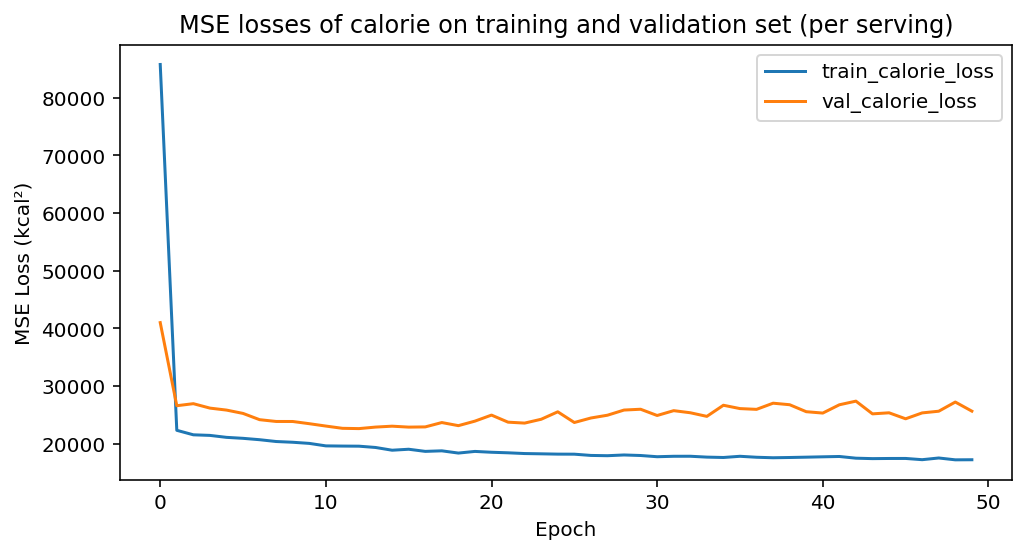

In [10]:
models_vectors.plot_training_losses()

In [29]:
# 读取测试图片，预测结果，并保存

imgs = load_test_images(test_data, target='serving')
models.predict_and_save_results(imgs)
models_nutrient.predict_and_save_results(imgs)
models_category.predict_and_save_results(imgs)
models_ingredient.predict_and_save_results(imgs)
models_vectors.predict_and_save_results(imgs)
models_vectors_three_classes.predict_and_save_results(imgs)

Loading 1132 test imgs (per serving)...


/usr/local/lib/python3.8/site-packages/PIL/Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Predicted results exist, try using object.load_pred_result()
Predicted results exist, try using object.load_pred_result()
Predicted results exist, try using object.load_pred_result()
Predicted results exist, try using object.load_pred_result()
Predicted results exist, try using object.load_pred_result()
Predicted results exist, try using object.load_pred_result()


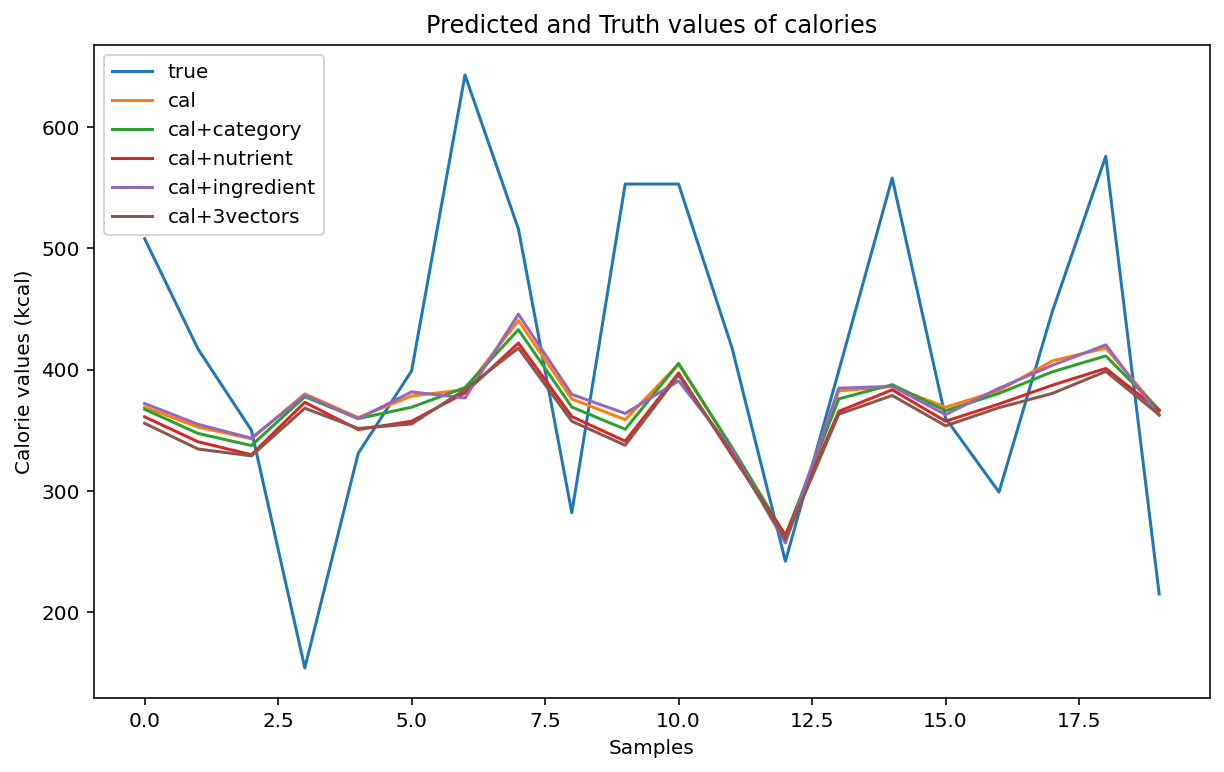

In [7]:
# joint plot of predicted calories of five models on some test samples

plot_calories_of_models(true_calorie, 180, 200, models, models_category, models_nutrient, models_ingredient, models_vectors)

       Truth calories  Predicted calories
count     1132.000000         1132.000000
mean       347.439046          354.903961
std        144.691577           35.336323
min         74.000000          246.871689
25%        240.000000          331.202118
50%        334.500000          354.552826
75%        455.250000          376.784943
max        650.000000          458.572205

Mean absolute errors of calorie:  118.83756172530643 kcal
Root mean squared errors of calorie:  142.24030059805145 kcal
R2 score of calorie:  0.03274129463208275
Mean absolute percentage error:  51.02721428056648
Mean relative errors of calorie:  48.504359190529016 %

Sample number with abs error greater than 120kcal: 202
Sample number with abs error less than 120kcal: 47
Sample number with relative error exceeds 50%:  281
Sample number with relative error less than 50%:  851


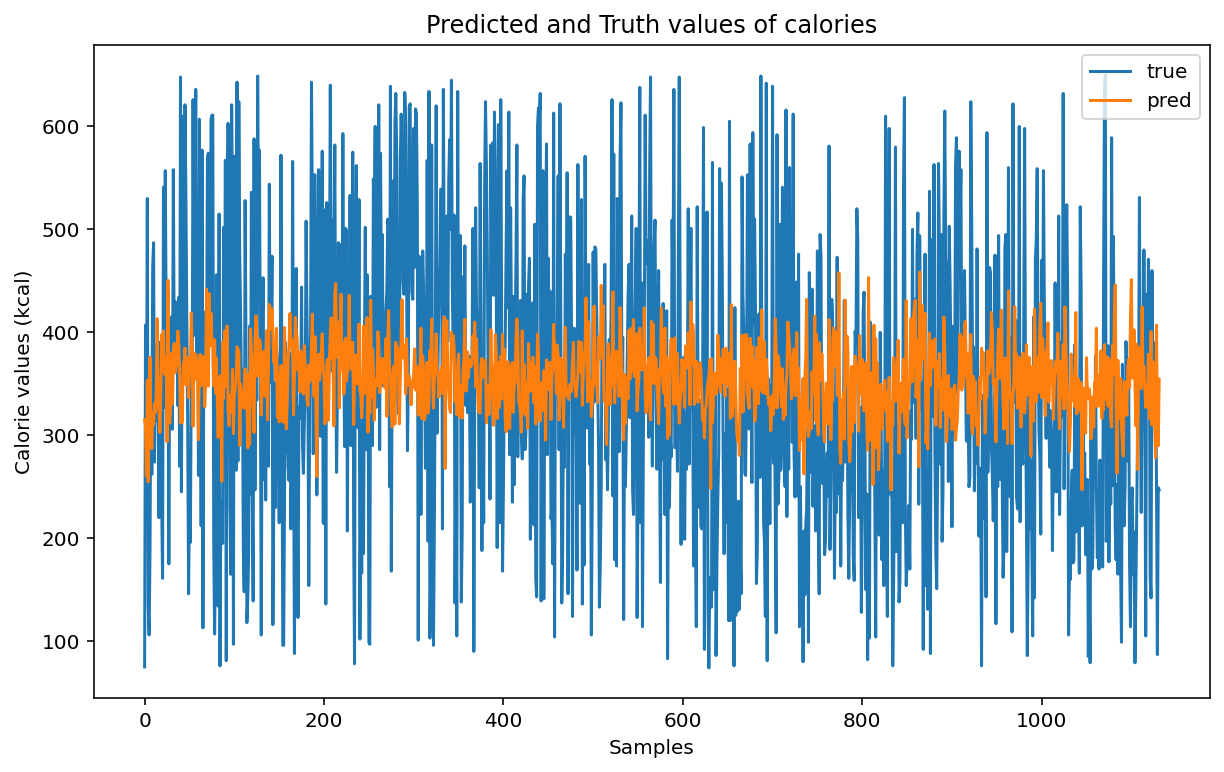

In [48]:
# evaluate the performance of predicting calories
# model that predicts the calories, category, nutrients, and top-100 ingredients simultaneously

models_vectors.evaluate_calorie(true_calorie)

In [24]:
models_vectors.evaluate_nutrient(true_nutrient)

Mean absolute errors of fat:  8.12233612326767 grams
Root mean squared errors of fat:  10.163741580681881 grams
R2 score of fat:  0.030358765119884557

Mean absolute errors of carbohydrates:  17.283739845154564 grams
Root mean squared errors of carbohydrates:  20.988842103388034 grams
R2 score of carbohydrates:  -0.013689109288550716

Mean absolute errors of protein:  11.496963986406898 grams
Root mean squared errors of protein:  13.604025274697078 grams
R2 score of protein:  -0.05521933750728736


In [116]:
models_vectors.evaluate_by_index(test_data, index=506, ingredient_list=ingredient_list)

Image name:  salad1148.jpg
                                                                                               True  \
Calorie                                                                                         291   
Category                                                                                      salad   
Fat                                                                                              10   
Carbohydrate                                                                                     27   
Protein                                                                                          19   
Ingredients   egg, garlic clove, onion, red onion, rapeseed oil, tomato, tomato pure, cider vinegar   

             Predicted  
Calorie        395.601  
Category         salad  
Fat            19.1322  
Carbohydrate   40.5498  
Protein        22.4655  
Ingredients             


In [114]:
models_vectors.df_by_index

True Predicted
Calorie                                                         362   331.775
Category                                                      salad     salad
Fat                                                              16   16.2856
Carbohydrate                                                     35   34.0742
Protein                                                          16   18.7212
Ingredients   olive oil, butter, bay leaf,  lemon, flatleaf parsley

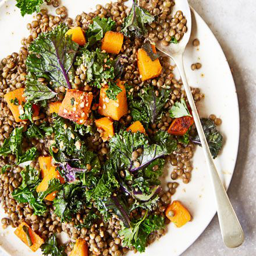

In [115]:
Image.fromarray(np.uint8(imgs[505]))

In [104]:
list(test_data[124:125]['parsed_ingredients'])

["['butter', 'selfraising flour', 'tsp powder', 'caster sugar', 'egg', 'milk', 'zest orange', 'orange juice', 'caster sugar', 'dark chocolate']"]

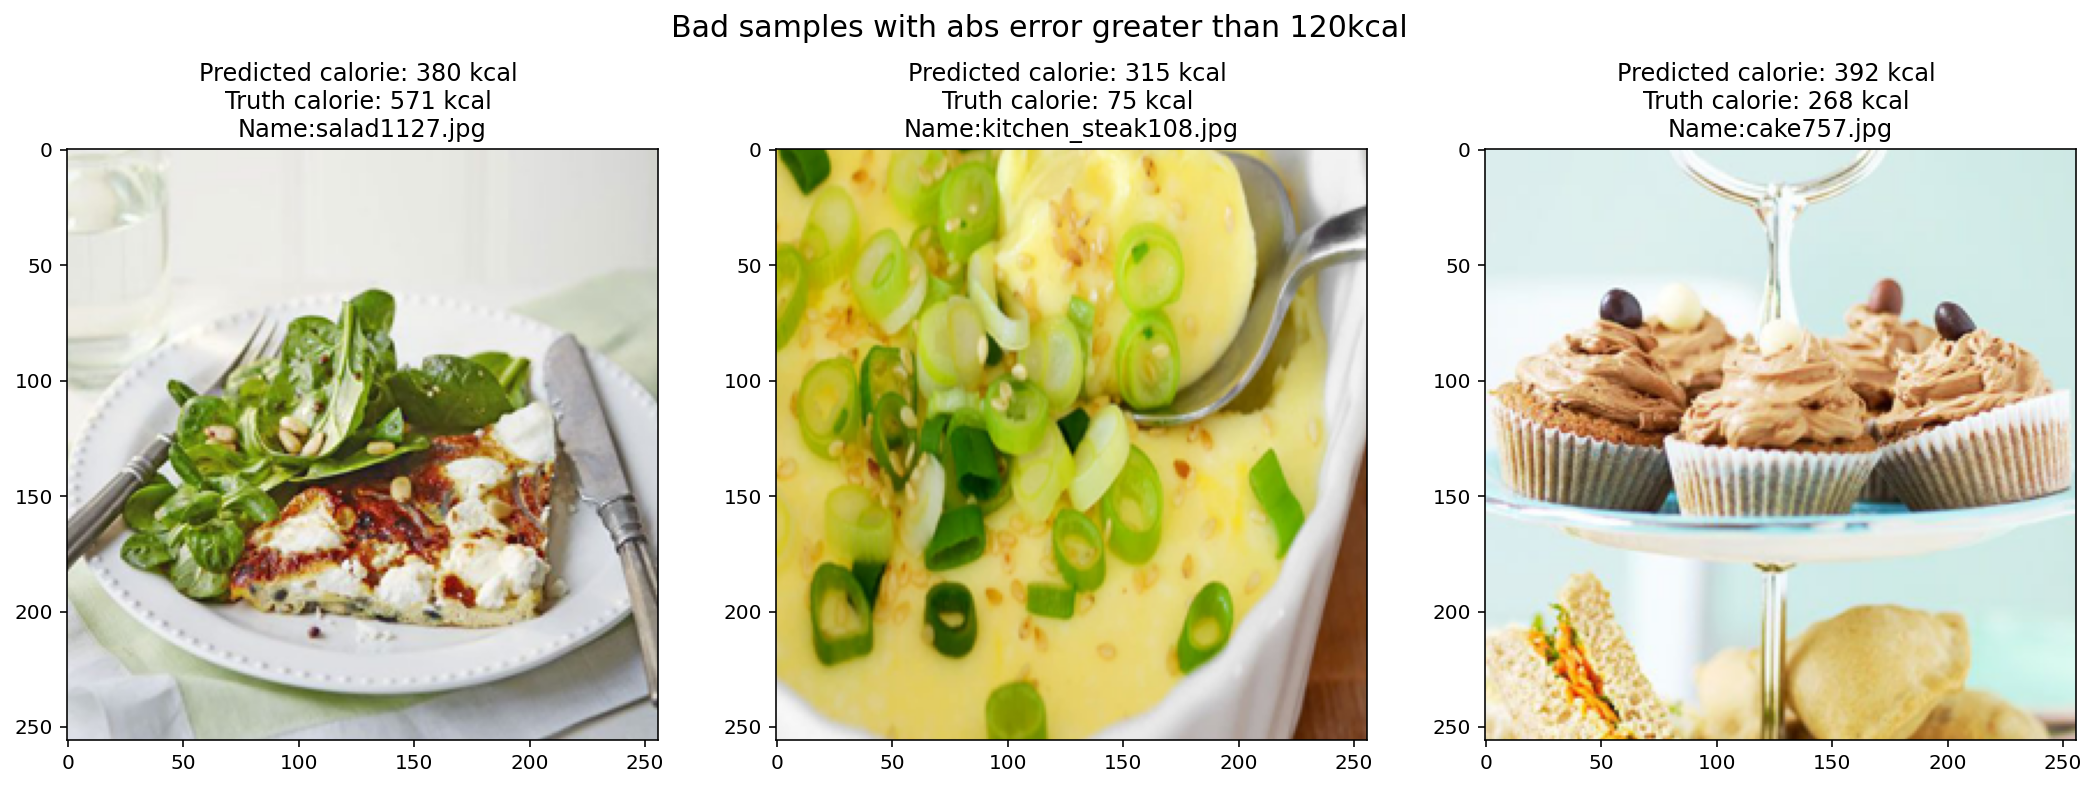

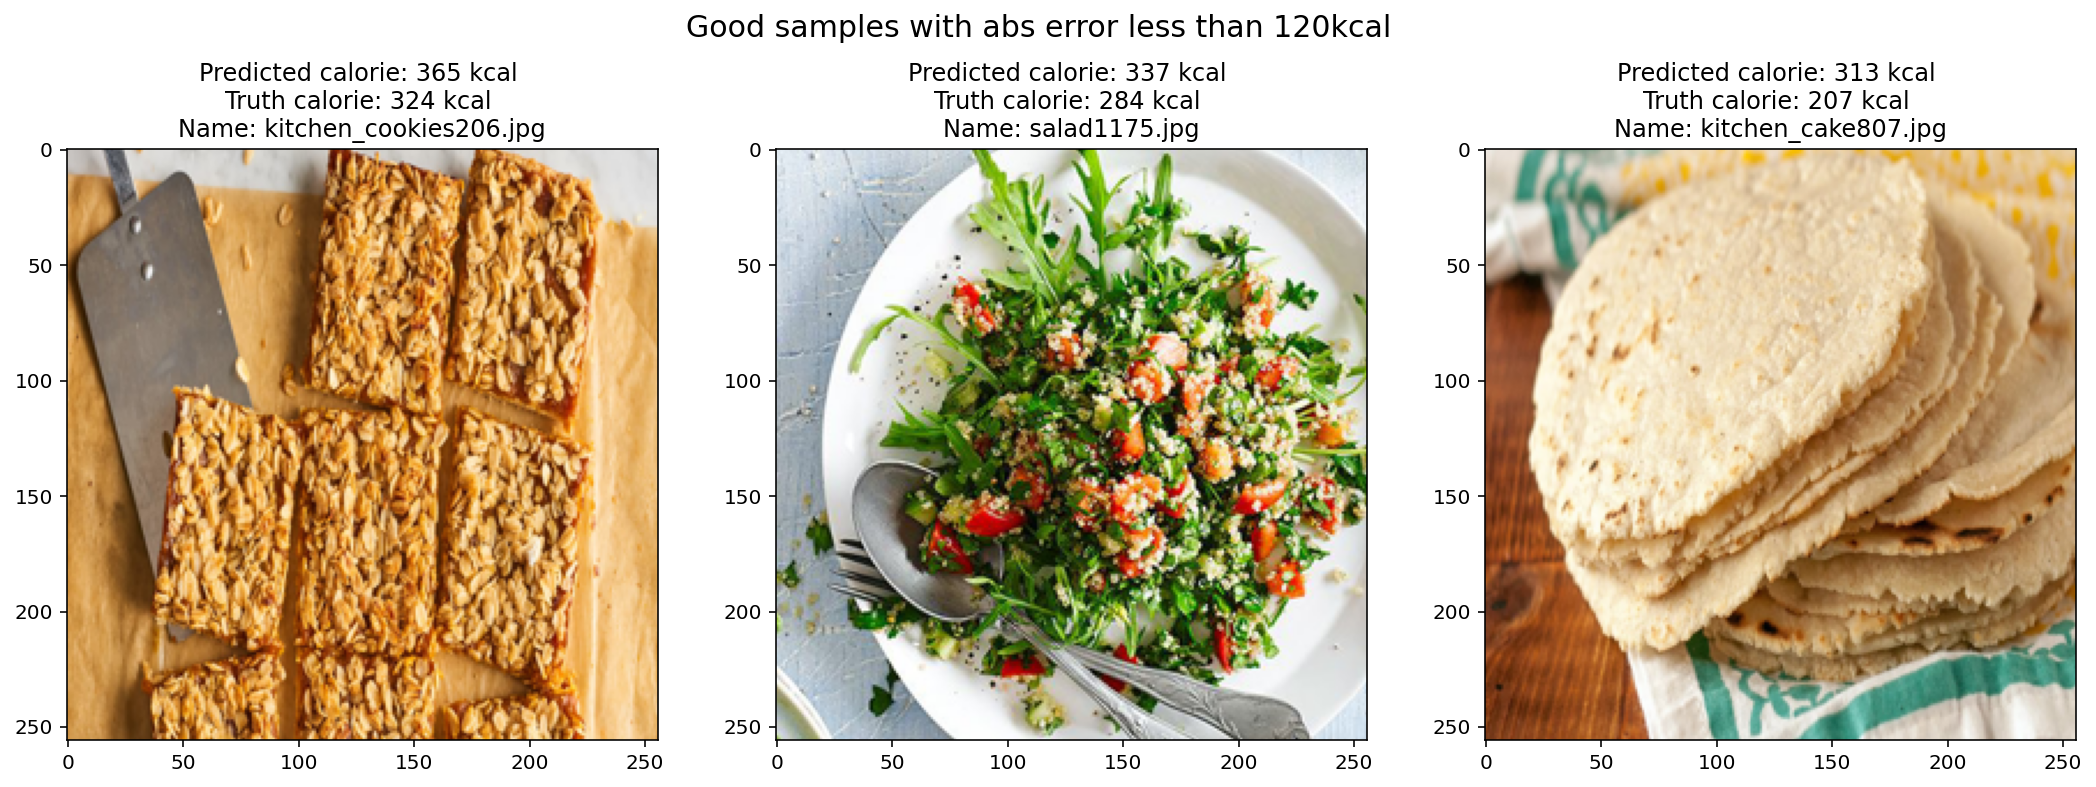

In [33]:
# visualize 3 good prediction results (abs error < 120kcal) and 3 bad prediction results (abs error > 120kcal)

models_vectors.visualize_samples(test_data, true_calorie, imgs)

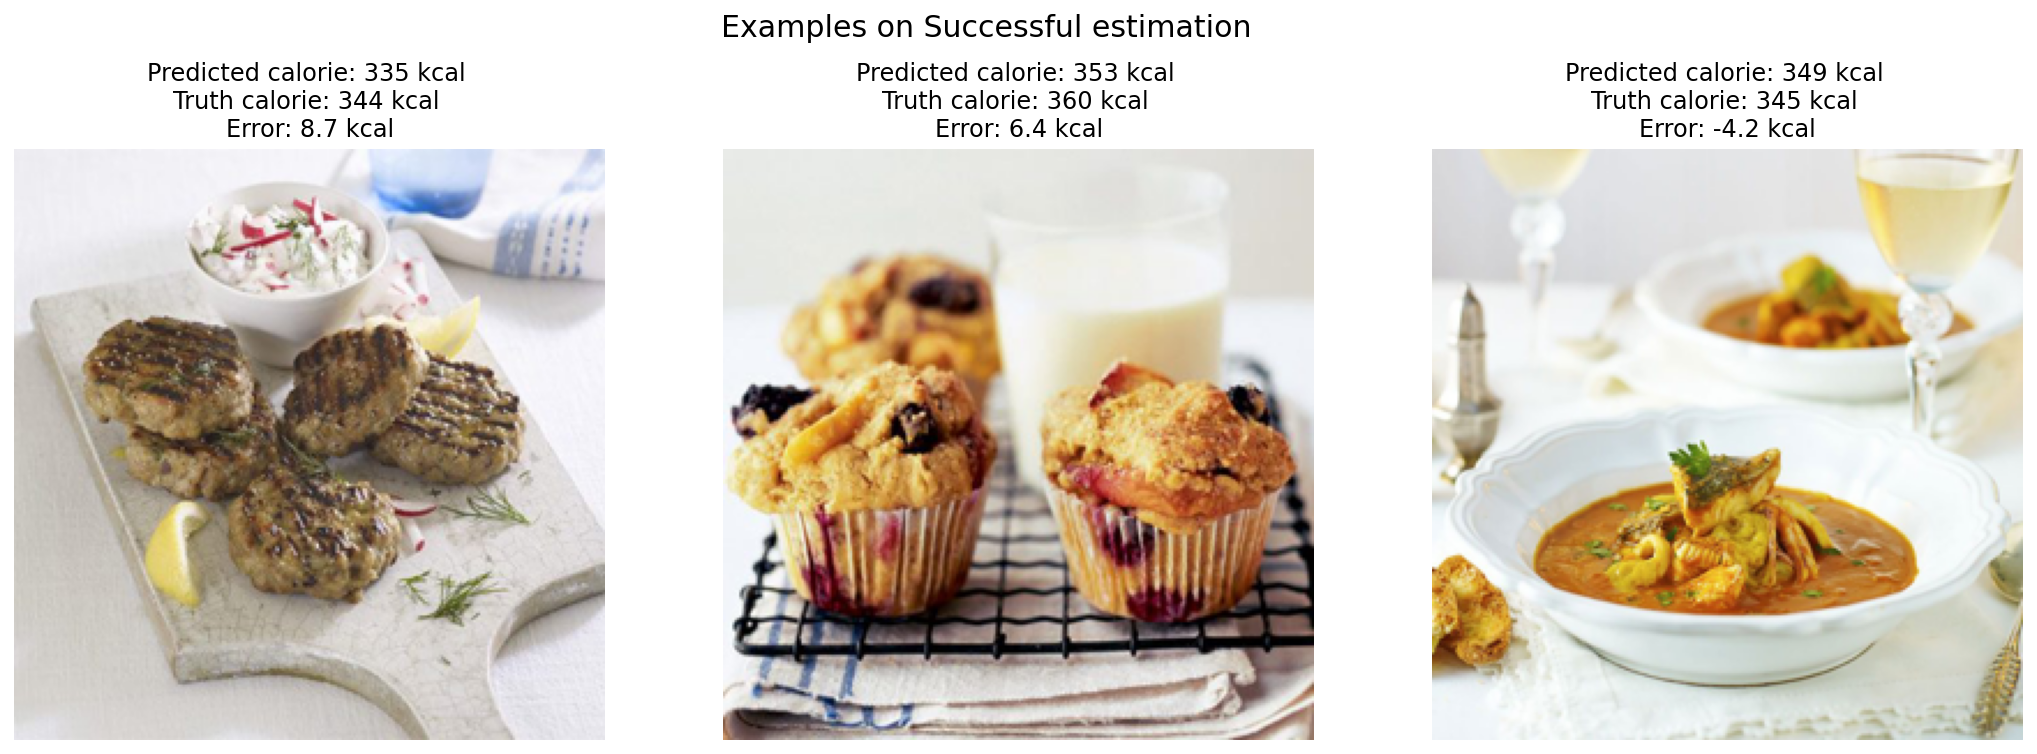

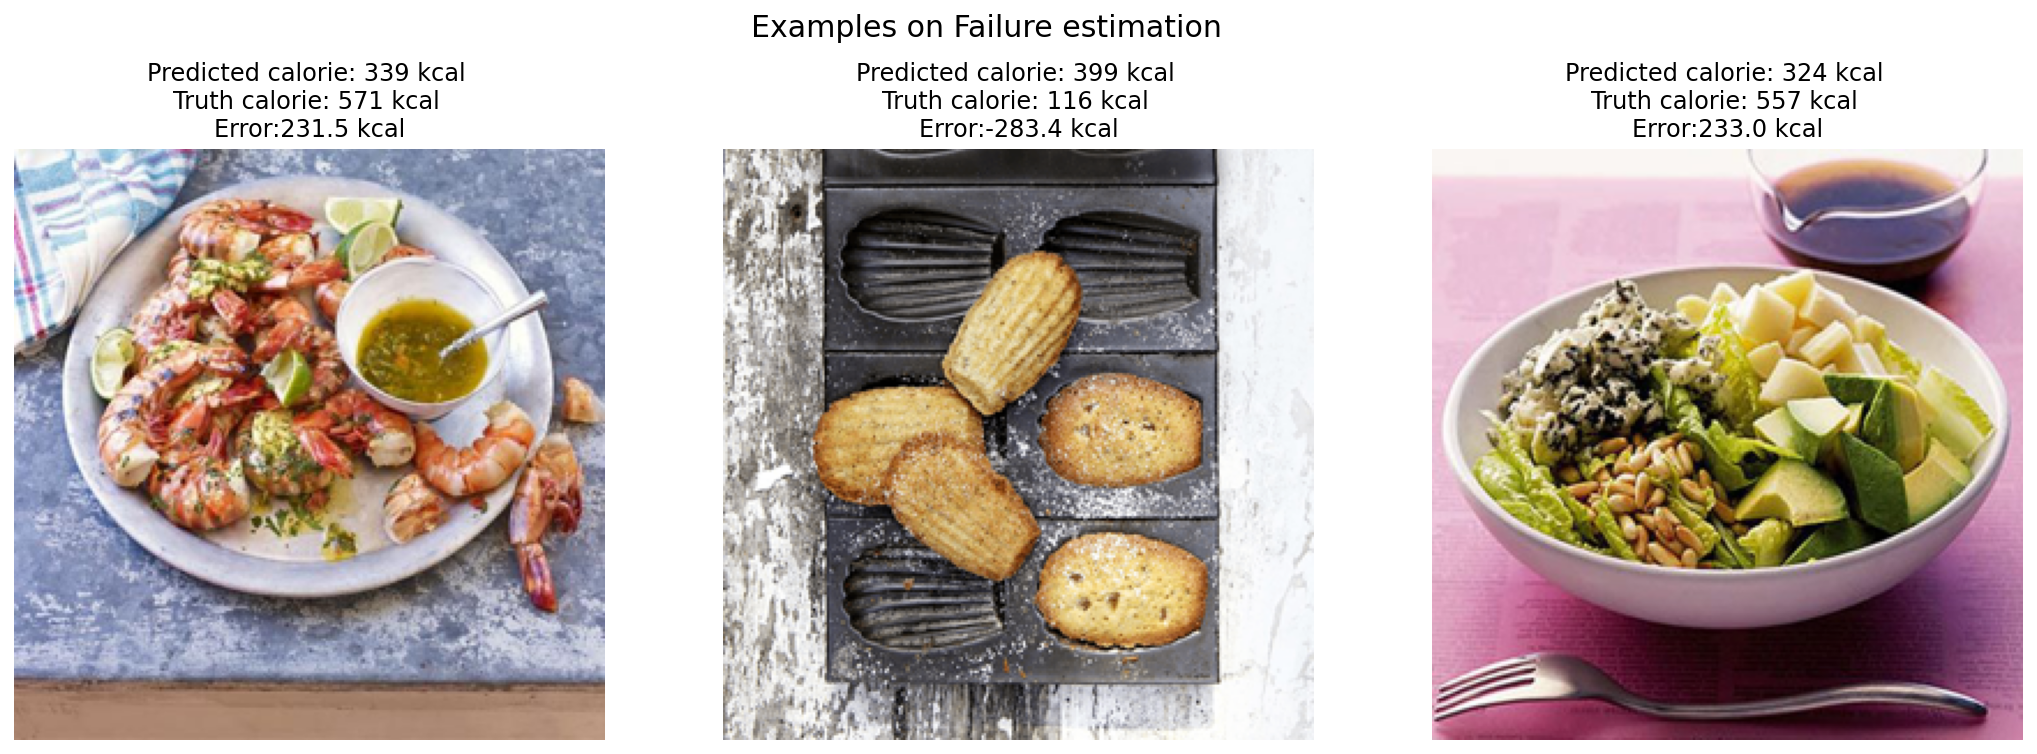

In [82]:
# visualize some samples with high errors (>200kcal) and low errors (<10kcal)

models_vectors.visualize_samples(test_data, true_calorie, imgs)

In [5]:
# comparison between the model trained on 12 categories and the model trained on 3 categories

pred_list = list(models_vectors.pred_calorie)
pred_list_3_classes = list(models_vectors_three_classes.pred_calorie)
test_data['pred_calorie_error'] = [np.abs((true_calorie[i] - pred_list[i])[0]) for i in range(len(true_calorie))]
test_data['pred_calorie_error_3class'] = [np.abs((true_calorie[i] - pred_list_3_classes[i]))[0] for i in range(len(true_calorie))]
test_data.groupby('category').mean()

serving     calorie  pred_calorie_error  pred_calorie_error_3class
category                                                                      
bread      6.071429  387.964286          113.485034                 117.062051
burger     8.870370  354.203704          161.971991                 158.988511
cake      10.537445  319.848485          108.182097                 110.606699
cookies   11.907407  331.446429          110.741458                 104.559784
pasta      4.953488  444.081395          126.419892                 138.930637
pie        7.512195  360.024390          126.455774                 126.471662
pizza      7.258065  332.419355           87.562089                  89.739994
rice       6.648438  373.117188          113.914386                 116.745602
salad      6.149485  341.515464          117.947877                 120.309748
sandwich   5.285714  351.800000          122.818864                 122.163152
soup      12.089888  272.344444          134.573885                 132.323489
steak      4.901639  332.524590          118.428772                 119.673406

Text(0.5, 1.0, 'Correlations between nutrients and calories on training set (Pearson)')

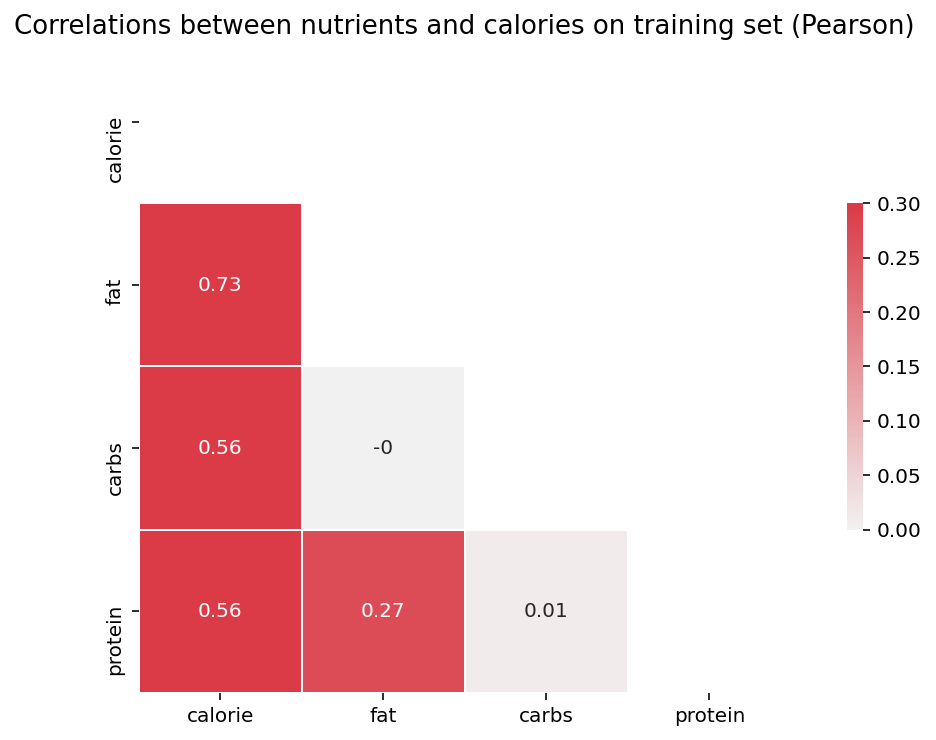

In [71]:
nutrient_cor = pd.DataFrame(test_data['calorie'])
nutrient_cor["fat"] = [true_nutrient[i][0] for i in range(len(true_nutrient))]
nutrient_cor["carbs"] = [true_nutrient[i][1] for i in range(len(true_nutrient))]
nutrient_cor["protein"] = [true_nutrient[i][2] for i in range(len(true_nutrient))]

corr_p = nutrient_cor.corr(method = 'pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_p, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(round(corr_p,2), annot = True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_title('Correlations between nutrients and calories on training set (Pearson)', fontsize = 13, pad = 1)

In [72]:
# correlation between truth and predicted calorie
coorelation_comp = pd.DataFrame(test_data['calorie'])
coorelation_comp['pred_calorie'] = [models_vectors.pred_calorie[i][0] for i in range(len(models_vectors.pred_calorie))]
coorelation_comp.corr(method = 'pearson')
coorelation_comp.corr(method = 'spearman')

calorie  pred_calorie
calorie       1.000000      0.219007
pred_calorie  0.219007      1.000000

## Evaluate per recipe

In [12]:
test_data = pd.read_csv('./data/per_recipe/test_per_recipe_complete.csv')
ingredient_list = list(pd.read_csv('./data/per_recipe/top_100_ingre_per_recipe.csv')['ingredient'])
test_data['category_vector'] = test_data['category_vector'].apply(ast.literal_eval)
test_data['nutrient_vector'] = test_data['nutrient_vector'].apply(ast.literal_eval)
test_data['ingredient_vector'] = test_data['ingredient_vector'].apply(ast.literal_eval)

true_calorie = list(test_data['calorie_per_recipe'])
true_nutrient = list(test_data['nutrient_vector'])
true_category = list(test_data['category_vector'])
true_ingredient = list(test_data['ingredient_vector'])

In [8]:
train_data = pd.read_csv('./data/per_recipe/train_per_recipe_complete.csv')
train_data['category_vector'] = train_data['category_vector'].apply(ast.literal_eval)
train_data['nutrient_vector'] = train_data['nutrient_vector'].apply(ast.literal_eval)
train_data['ingredient_vector'] = train_data['ingredient_vector'].apply(ast.literal_eval)
print_mean_baseline_error(train_data, test_data, true_nutrient, "recipe")
print_random_baseline_error(train_data, test_data, true_nutrient, "recipe")

Mean baseline evaluation:
RMSE fat:  47.48450712716558
RMSE carbs:  105.04178305806934
RMSE protein:  54.77501063011336
Mean calorie per recipe:  1452.6884913316119
RMSE calorie:  755.5565278525418
MAE calorie:  644.6394118668281

Random baseline evaluation:
RMSE fat:  65.47409232876274
RMSE carbs:  147.74154626598087
RMSE protein:  75.93078688524004
RMSE calorie:  1077.5191193236453
MAE calorie:  861.923159018143


In [13]:
calorie_recipe_path = './server/models/per_recipe/calorie_recipe.h5'
calorie_nutrient_recipe_path = './server/models/per_recipe/calorie_nutrient_recipe.h5'
calorie_category_recipe_path = './server/models/per_recipe/calorie_category_recipe.h5'
calorie_ingredient_recipe_path = './server/models/per_recipe/calorie_ingredient_recipe.h5'
calorie_three_vector_recipe_path = './server/models/per_recipe/calorie_three_vector_recipe.h5'

# models for model_per_serving; modelr for model_per_recipe
modelr = Evaluator(calorie_recipe_path, output_type='calorie')
modelr_nutrient = Evaluator(calorie_nutrient_recipe_path, output_type='nutrient')
modelr_category = Evaluator(calorie_category_recipe_path, output_type='category')
modelr_ingredient = Evaluator(calorie_ingredient_recipe_path, output_type='ingredient')
modelr_vectors = Evaluator(calorie_three_vector_recipe_path, output_type='three_vector')

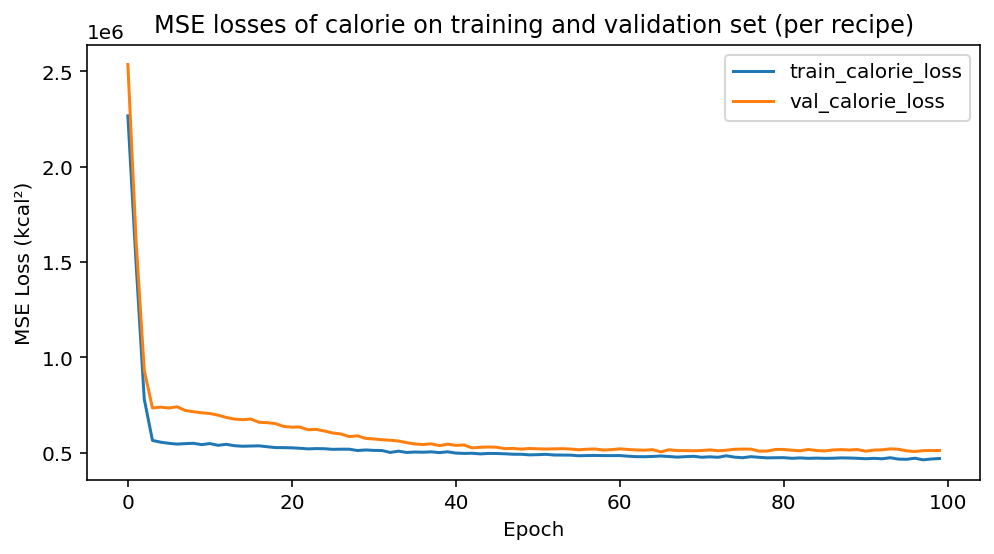

In [14]:
modelr_vectors.plot_training_losses()

       Truth calories  Predicted calories
count      937.000000          937.000000
mean      1424.013874         1584.107300
std        755.415418          238.464874
min          6.000000          818.458984
25%        788.000000         1430.710205
50%       1380.000000         1574.759644
75%       2048.000000         1737.940552
max       2912.000000         2348.190186

Mean absolute errors of calorie:  624.3658662875408 kcal
Root mean squared errors of calorie:  737.4226757541123 kcal
R2 score of calorie:  0.04605128112065582
Mean absolute percentage error:  164.24375221406865
Mean relative errors of calorie:  142.9196500948749 %

Sample number with abs error greater than 120kcal: 839
Sample number with abs error less than 120kcal: 98
Sample number with relative error exceeds 50%:  350
Sample number with relative error less than 50%:  587


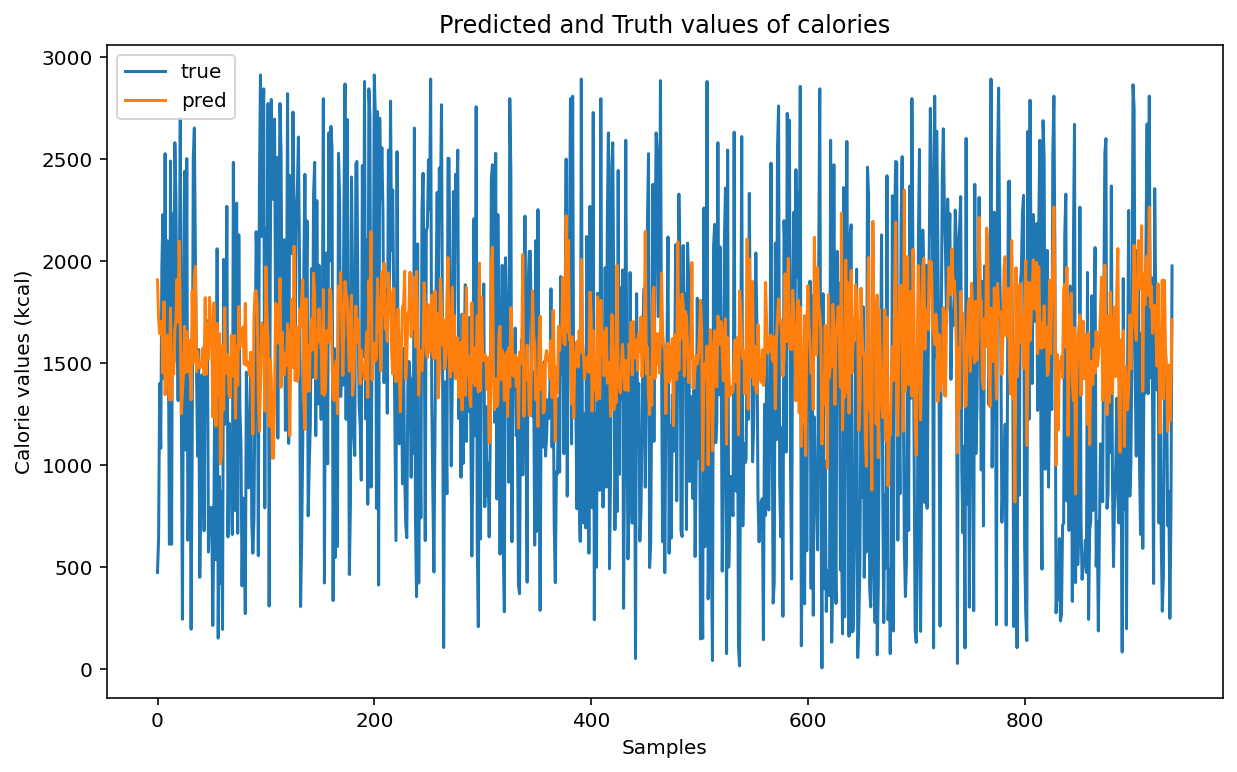

In [10]:
# nutrient结果提升最少，ingredient结果提升最多，category还行

modelr_vectors.evaluate_calorie(true_calorie)

In [13]:
modelr_vectors.evaluate_nutrient(true_nutrient)

Mean absolute errors of fat:  37.719159358135535 grams
Root mean squared errors of fat:  46.25824499761452 grams
R2 score of fat:  0.05051755798432889

Mean absolute errors of carbohydrates:  92.26557269834277 grams
Root mean squared errors of carbohydrates:  108.68497397831332 grams
R2 score of carbohydrates:  -0.07919007167511283

Mean absolute errors of protein:  43.46857092092996 grams
Root mean squared errors of protein:  54.30253760165966 grams
R2 score of protein:  0.017104613227680643


In [16]:
print(test_data.groupby('category').mean())

           serving     calorie  calorie_per_recipe
category                                          
bread     3.900000  419.585714         1493.571429
burger    4.469388  314.795918         1204.877551
cake      5.656716  265.589552         1350.485075
cookies   8.666667  243.285714         1480.095238
pasta     3.954023  466.758621         1730.689655
pie       5.517241  331.379310         1651.293103
pizza     4.111111  391.740741         1391.444444
rice      4.201681  390.756303         1579.025210
salad     4.000000  363.009950         1317.716418
sandwich  3.916667  405.694444         1394.638889
soup      5.294118  257.917647         1320.929412
steak     4.080000  395.080000         1190.000000


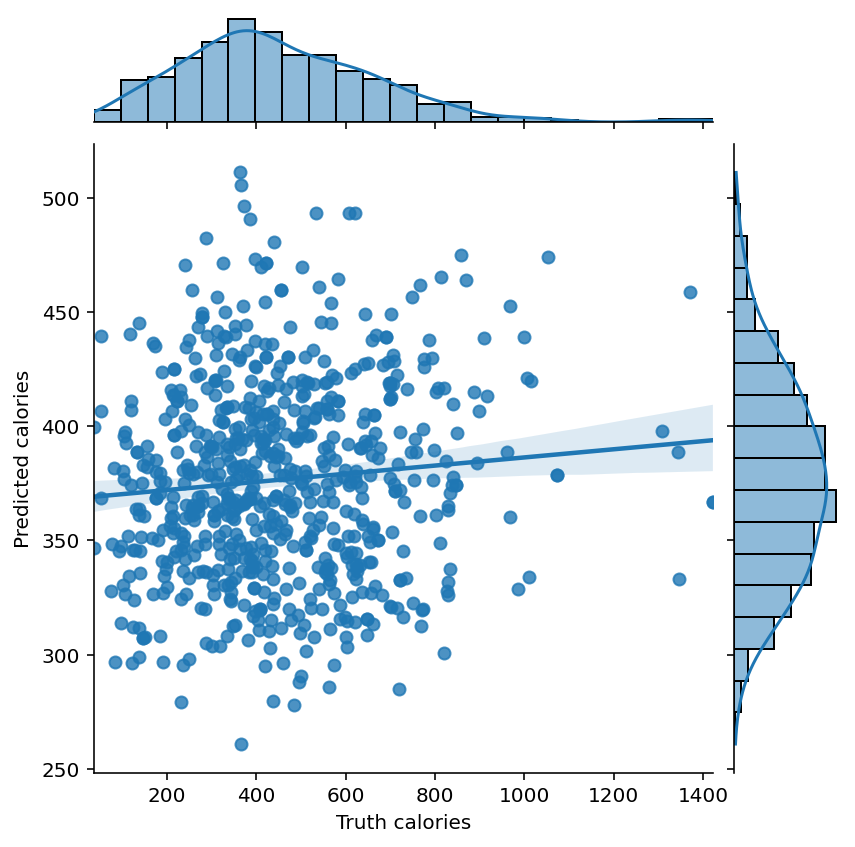

In [5]:
import seaborn as sns

calorie_table = pd.DataFrame(true_calories, columns=['Truth calories'])
calorie_table['Predicted calories'] = pred_calories
ax = sns.jointplot(x='Truth calories', y='Predicted calories', data=calorie_table, kind='reg')

In [ ]:
# ingredient 阈值为4预测结果只有0，2，3？？？

models_ingredient.pred_ingredient[2]

for k in range(len(models_ingredient.pred_ingredient)):
    if [i for (i, v) in enumerate(models_ingredient.pred_ingredient[k]) if v > 0.4] != [0, 3]:
        if [i for (i, v) in enumerate(models_ingredient.pred_ingredient[k]) if v > 0.4] != [0, 2]:
            if [i for (i, v) in enumerate(models_ingredient.pred_ingredient[k]) if v > 0.4] != [0]:
                if [i for (i, v) in enumerate(models_ingredient.pred_ingredient[k]) if v > 0.4] != []:
                    if [i for (i, v) in enumerate(models_ingredient.pred_ingredient[k]) if v > 0.4] != [2]:
                        print(k)
                        
                        
for i in range(1000):
    if np.argmax(models_vectors.pred_category[i]) != 8:
        print(np.argmax(models_vectors.pred_category[i]))

### Take a closer look at the results of different categories

In [127]:
results = test_data.drop(columns=['title', 'image', 'ingredients', 'nutrients', 'parsed_ingredients', "ingredient_vector", 'nutrient_vector'])
results['truth_calorie'] = true_calories
results['pred_calorie'] = pred_calories
results['category'] = [re.findall("\D+", i)[0] for i in results['file_name']]
results.head()
#results.to_csv('./data/evaluate/pred_results.csv', index=False)

file_name  truth_calorie  pred_calorie category
0  bread384.jpg          237.0    375.079468    bread
1  bread386.jpg          700.0    411.921051    bread
2  bread387.jpg          541.0    460.738159    bread
3  bread388.jpg          327.0    424.348053    bread
4  bread389.jpg          557.0    407.534912    bread

In [133]:
results['abs_error'] = np.abs(results['truth_calorie'] - results['pred_calorie'])
results['rmse_error'] = np.abs(results['truth_calorie'] - results['pred_calorie'])
results

file_name  truth_calorie  pred_calorie category   abs_error
0    bread384.jpg          237.0    375.079468    bread  138.079468
1    bread386.jpg          700.0    411.921051    bread  288.078949
2    bread387.jpg          541.0    460.738159    bread   80.261841
3    bread388.jpg          327.0    424.348053    bread   97.348053
4    bread389.jpg          557.0    407.534912    bread  149.465088
..            ...            ...           ...      ...         ...
691  steak258.jpg          672.0    350.055969    steak  321.944031
692  steak259.jpg          124.0    345.827820    steak  221.827820
693  steak260.jpg          642.0    405.510681    steak  236.489319
694  steak261.jpg           81.0    381.499146    steak  300.499146
695  steak262.jpg         1014.0    419.842957    steak  594.157043

[696 rows x 5 columns]

In [137]:
category_names = list(set(results['category']))


['pie',
 'soup',
 'cake',
 'burger',
 'pasta',
 'pizza',
 'rice',
 'steak',
 'cookies',
 'bread',
 'salad',
 'sandwich']

In [140]:
results.groupby('category').mean()
#https://blog.csdn.net/shijie97/article/details/100203634

truth_calorie  pred_calorie   abs_error
category                                         
bread        459.083333    387.244182  152.671840
burger       438.975610    369.627067  229.622945
cake         434.603960    404.820938  135.012073
cookies      457.434783    412.539125  144.818313
pasta        547.059701    352.666972  220.440473
pie          511.919355    371.775146  213.840515
pizza        539.117647    385.249652  184.647867
rice         443.720588    359.302767  154.250567
salad        416.500000    371.785615  151.180247
sandwich     478.739130    384.581024  176.861446
soup         344.200000    368.052980  172.872733
steak        512.709677    372.226837  283.609398